In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable  

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from tqdm import tqdm
import warnings; warnings.simplefilter('ignore')
import pickle
import scipy
from scipy.special import softmax
import sys
from sklearn.feature_extraction.text import CountVectorizer as CV
import re
import copy
from itertools import combinations 

from gensim.models import KeyedVectors

from sklearn_crfsuite import CRF
import nltk

# if gpu is to be used
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print ("== Cuda: {} ===".format(torch.cuda.is_available()))

== Cuda: True ===


In [ ]:
# Sequence Loader
class BuildDataLoader:
    
    def __init__(self, source, folder, num_flag, embed_flag):
        self.sequence = []
        self.word_dict = {}
        self.label_dict = {}
        self.num_flag = num_flag
        self.embed_flag = embed_flag
        self.folder = folder

        if source == 'conll':
            with open(folder + "train.txt", 'r') as file:
                x=[]
                y=[]
                for line in file:
                    tokens = line.replace("\n",'').split()
                    if len(tokens) < 1:
                        self.sequence.append((x,y))
                        x = []
                        y = []
                    else:
                        char = tokens[0]
                        label = tokens[2]
                        if self.num_flag and char.replace('.','').isdigit():
                            char = 'NUM'
                        x.append(char)
                        y.append(label)
                        if char not in self.word_dict:
                            self.word_dict[char] = len(self.word_dict)
                        if label not in self.label_dict:
                            self.label_dict[label] = len(self.label_dict)
        else:
            with open(folder + '_string.txt', 'r') as x_file, open(folder + '_label.txt', 'r') as y_file: 
                for x, y in zip(x_file, y_file):
                    x = [char for char in x.replace("\n",'')]
                    y = y.replace("\n",'').split(',')
                    if(len(y) > 1):
                        if len(y[-1]) == 0:
                            y = y[:-1]
                        if self.num_flag:
                            for i in range(len(x)):
                                if x[i].isdigit():
                                    x[i] = 'x'
                        for char, label in zip(x, y):
                            if char not in self.word_dict:
                                self.word_dict[char] = len(self.word_dict)
                            if label not in self.label_dict:
                                self.label_dict[label] = len(self.label_dict)
                        self.sequence.append((x, y))
    
    def shuffle(self, seed = 4):
        random.Random(4).shuffle(self.sequence)
    
    def seqs2Tensor(self, sequence):
        if self.embed_flag:
            num_str = "NUM" if self.num_flag else ""
            wv = KeyedVectors.load(self.folder + "word2vec" + num_str + ".kv", mmap='r')
            char_embed = []
            for j, char in enumerate(sequence[0]):
                    char_embed.append(wv[char])
            tensor = torch.from_numpy(np.array(char_embed)).type(torch.FloatTensor)
            return tensor.unsqueeze(0).to(device)
        else:
            tensor = torch.zeros(len(sequence[0]), len(self.word_dict), device=device)
            for j, char in enumerate(sequence[0]):
                    tensor[j][self.word_dict[char]] = 1
            return tensor.unsqueeze(0).to(device)
    
    def get_embed_size(self):
        if self.embed_flag:
            num_str = "NUM" if self.num_flag else ""
            wv = KeyedVectors.load(self.folder + "word2vec" + num_str + ".kv", mmap='r')
            return wv.vector_size
        else:
            return len(self.word_dict)
    
    def get_word_dict(self):
        return self.word_dict
    
    def get_label_dict(self):
        return self.label_dict

In [ ]:
# CRF
class CrfModel(object):
    
    def __init__(self, data, feature):
        self.label_dict = data.label_dict
        self.word_dict = data.word_dict
        self.num_flag = data.num_flag
        self.feature = feature
        
        self.crf = CRF(
            algorithm='lbfgs',
            c1=0.1,
            c2=0.1,
            max_iterations=100,
            all_possible_transitions=True
        )
        
        self.X_train=[]
        self.Y_train=[]
    
        print ('label dict size: {}'.format(len(self.label_dict)))
        print ('word dict size: {}'.format(len(self.word_dict)))
    def reset(self):
        self.X_train=[]
        self.Y_train=[]
    
    def char2feature(self, sent, i):
        # for current character
        w = sent[i]
        if self.num_flag and w.isdigit():
            w = 'x'
        features = {'0:word': w}
        # for previous character
        if i > 0:
            w = sent[i-1]
            if self.num_flag and w.isdigit():
                w = 'x'
            features.update({'-1:word': w})
        # for next character
        if i < len(sent)-1:
            w = sent[i+1]
            if self.num_flag and w.isdigit():
                w = 'x'
            features.update({'+1:word': w})
        return features
    
    def add_instances(self, sequences):
        for seq in sequences:
            x = seq[0]
            y = seq[1]
            self.X_train.append([self.char2feature(x, i) for i in range(len(x))])
            self.Y_train.append(y)
    
    def compute_confidence(self, sequence):
        x = [self.char2feature(sequence[0], i) for i in range(len(sequence[0]))]
        y_pred = self.crf.tagger_.tag(x)
        prob_norm = math.exp(math.log(self.crf.tagger_.probability(y_pred)) / len(x))
        
        label_list = self.crf.tagger_.labels()
        prob_list = []
        for i in range(len(x)):
            marginal_prob = [self.crf.tagger_.marginal(k, i) for k in label_list]
            prob_list.append(max(marginal_prob))
        return (prob_list, sum(prob_list), prob_norm)
    
    def compute_entropy(self, sequence):
        x = [self.char2feature(sequence[0], i) for i in range(len(sequence[0]))]
        label_list = self.crf.tagger_.labels()
        self.crf.tagger_.set(x)
        entropy_seq = []
        for i in range(len(x)):
            marginal_prob = [self.crf.tagger_.marginal(k, i) for k in label_list]
            entropy_seq.append(scipy.stats.entropy(marginal_prob))
        return (entropy_seq, sum(entropy_seq))
    
    def train(self):
        self.crf.fit(self.X_train, self.Y_train) 
        return len(self.X_train)
    
    def predict(self, sequence):
        x = [self.char2feature(sequence[0], i) for i in range(len(sequence[0]))]
        return self.crf.tagger_.tag(x)    
    
    def evaluate_acc(self, sequences):
        # Calculate phrase-level accuracy and out-of-phrase accuracy
        X_test = [[self.char2feature(seq[0], i) for i in range(len(seq[0]))] for seq in sequences]
        Y_test = [seq[1] for seq in sequences]
        Y_pred = self.crf.predict(X_test)
        
        # Consider the accuracy in phrase level.
        in_cnt,  in_crt = 0, 0    # Total/correct number of phrases
        out_cnt, out_crt = 0, 0   # Total/correct number of "o"
        all_cnt, all_crt = 0, 0   # Total/correct number of all words

        acc = []
        for y_test, y_pred in zip(Y_test, Y_pred):
            cnt, crt = 0, 0
            correct_flag = False
            for j in range(len(y_test)):
                all_cnt += 1
                cnt += 1
                if y_test[j] == y_pred[j]:
                    all_crt += 1
                    crt += 1

                # If the character is a beginning-of-phrase.
                if y_test[j][0] == 'b' or y_test[j][0] == 'B':
                    in_cnt += 1
                    if y_test[j] == y_pred[j]:
                        if correct_flag:
                            in_crt += 1
                        correct_flag = True
                    else:
                        if correct_flag:
                            if y_pred[j][2:] != y_pred[j-1][2:]:  # special case
                                in_crt += 1
                        correct_flag = False

                # If the character is an inside-of-phrase.
                elif y_test[j][0] == 'i' or y_test[j][0] == 'I':
                    if y_test[j] != y_pred[j]:
                        correct_flag = False

                # If the character is an out-of-phrase.
                elif y_test[j][0] == 'o' or y_test[j][0] == 'O':
                    out_cnt += 1
                    if y_test[j] == y_pred[j]:
                        out_crt += 1
                        if correct_flag:
                            in_crt += 1
                            correct_flag = False
                    else:
                        if correct_flag:
                            if y_pred[j][2:] != y_pred[j-1][2:]:  # special case
                                in_crt += 1
                            correct_flag = False

            acc.append(crt/cnt)
            # For the case where the phrase is at the end of a string.
            if correct_flag:
                in_crt += 1
        in_acc = 0 if in_cnt == 0 else in_crt/in_cnt
        out_acc = 0 if out_cnt == 0 else out_crt/out_cnt
        all_acc = 0 if all_cnt == 0 else all_crt/all_cnt 
            
        return in_acc, out_acc, all_acc, sum(acc)/len(acc)
    
    def get_parameters(self):
        loc = {'0':0, '-1':1, '+1':2}
        if self.feature == 'all':
            paras = torch.zeros(len(loc) * len(self.word_dict) + len(self.label_dict), len(self.label_dict), device=device)
            for (attr, label), weight in self.crf.state_features_.items():
                attr = attr.split(":")
                dim1 = loc[attr[0]] * self.word_dict[':'.join(attr[2:])]
                dim2 = self.label_dict[label]
                paras[dim1][dim2] = weight
            for (label_from, label_to), weight in self.crf.transition_features_.items():
                dim1 = len(loc) * len(self.word_dict) + self.label_dict[label_from]
                dim2 = self.label_dict[label_to]
                paras[dim1][dim2] = weight
        elif self.feature == 'node':
            paras = torch.zeros(len(loc) * len(self.word_dict), len(self.label_dict), device=device)
            for (attr, label), weight in self.crf.state_features_.items():
                attr = attr.split(":")
                dim1 = loc[attr[0]] * self.word_dict[':'.join(attr[2:])]
                dim2 = self.label_dict[label]
                paras[dim1][dim2] = weight
        else:
            paras = torch.zeros(len(self.label_dict), len(self.label_dict), device=device)
            for (label_from, label_to), weight in self.crf.transition_features_.items():
                dim1 = self.label_dict[label_from]
                dim2 = self.label_dict[label_to]
                paras[dim1][dim2] = weight
                
        paras = paras.unsqueeze(0).unsqueeze(0).to(device) # batch, channel, w, h
        return paras

In [ ]:
# Vectorize a set of string by n-grams.
def string_vectorize(Xs_list):
    vc = CV(analyzer='char_wb', ngram_range=(3, 4), min_df=1, token_pattern='[a-z]{2,}')
    name = []
    for i in Xs_list:
        s = re.findall('(?i)[a-z]{2,}', "".join(str(x) for x in i))
        name.append(' '.join(s))
    vc.fit(name)
    vec = vc.transform(name).toarray()
    # print(name)
    # print(vec)
    dictionary = vc.get_feature_names()
    return vec, dictionary

In [ ]:
# replay buffer: a cyclic buffer of bounded size that holds the transitions observed recently
Transition = namedtuple('Transition',
                       ('state', 'action', 'next_state', 'reward', 'sequences'))

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    

In [ ]:
# Q-network
class DQN(nn.Module):
    
    def __init__(self, para_h, para_w, w_dim, rnn_hidden, n_filters, filter_size, n_stride):
        super(DQN, self).__init__()
        
        # CNN for CRF parameters
        self.conv1 = nn.Conv2d(
                in_channels=1,              
                out_channels=n_filters,   
                kernel_size=filter_size,              
                stride=n_stride,        
            )
        self.bn1 = nn.BatchNorm2d(n_filters)
        self.conv2 = nn.Conv2d(n_filters, n_filters*2, filter_size, n_stride)
        self.bn2 = nn.BatchNorm2d(n_filters*2)
        self.conv3 = nn.Conv2d(n_filters*2, n_filters*2, filter_size, n_stride)
        self.bn3 = nn.BatchNorm2d(n_filters*2)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = filter_size, stride = n_stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(para_w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(para_h)))
        linear_input_size = convw * convh * n_filters * 2
        
        self.fc1 = nn.Linear(linear_input_size, rnn_hidden)
        
        # LSTM for w sequence
        self.rnn = nn.LSTM(
            input_size=w_dim,
            hidden_size=rnn_hidden, 
            num_layers=1,
            batch_first=True,  # input＆output (batch，time_step，input_size)
        )
        
        # Fully connected layer
        self.fc = nn.Linear(2 * rnn_hidden, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, crf_x, seq_x):
        # CNN
        x1 = F.relu(self.bn1(self.conv1(crf_x)))
        x1 = F.relu(self.bn2(self.conv2(x1)))
        x1 = F.relu(self.bn3(self.conv3(x1)))
        x1 = F.relu(self.fc1(x1.view(x1.size(0), -1)))
        
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size) 
        # h_c shape (n_layers, batch, hidden_size)
        r_out,_ = self.rnn(seq_x, None) 
        # output of last time step
#         rnn_out = self.out(r_out[:, -1, :])
        x2 = r_out[:, -1, :]
        x = torch.cat((x1, x2), 1)
        
        return self.fc(x) # flatten the output

In [ ]:
def select_action(state, sequences, greedy_select):
    max_idx = 0
    
    if greedy_select == 'te':
        prob_list = []
        for seq in sequences:
            (prob_per_token, prob_sum) = crf.compute_entropy(seq)
            prob_list.append(prob_sum/len(seq[1]))
        # normalize
        mean_prob = np.mean(prob_list)
        std_prob = np.std(prob_list)
        prob_list = [(prob_list[i] - mean_prob) / std_prob for i in range(len(sequences))]
        max_idx = np.argsort(np.array(prob_list), kind='mergesort').tolist()[::-1][0]
    
    max_q_value = policy_net(state, data.seqs2Tensor(sequences[max_idx]))

    global steps_done
    sample = random.random()
    eps_threshold = 0.3
#     eps_threshold = EPS_END + (EPS_START - EPS_END) * \
#         math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample < eps_threshold:
        return (0, max_idx, max_q_value)
    
    for i in range(len(sequences)):
        seq = sequences[i]
#         q_value = policy_net(get_state_action(seq, state))
        q_value = policy_net(state, data.seqs2Tensor(seq))
        if max_q_value < q_value:
            max_q_value = q_value
            max_idx = i
    return (1, max_idx, max_q_value)

In [ ]:
def calculate_reward(crf, validation_list, test_list, sim_weight, trans_flag):
    if trans_flag == 'test3T' or trans_flag == 'test2T':
        source_seqs = test_list
        target_seqs = test_list
    elif trans_flag == 'valid3V' or trans_flag == 'valid2V':
        source_seqs = validation_list
        target_seqs = validation_list
    else:
        source_seqs = validation_list
        target_seqs = test_list

    source_q = gen_dataDistr(source_seqs)
    target_q = gen_dataDistr(target_seqs)
    acc_reweight = []
    idx = []
    for i, seq in enumerate(source_seqs):
        _, _, _, acc = crf.evaluate_acc([seq])
        x = ",".join(str(char) for char in seq[1])
        ratio_source = source_q[x] / len(source_seqs)
        if trans_flag == 'kmers':
            acc_reweight.append(sim_weight[i] * acc)
            idx.append(i)
        elif x in target_q:
            ratio_target = target_q[x] / len(target_seqs)
            if trans_flag == 'test2T' or trans_flag == 'valid2V' or trans_flag == 'valid2T':
                acc_reweight.append(acc)
                idx.append(i)
            elif trans_flag == 'test3T' or trans_flag == 'valid3V':
                acc_reweight.append(ratio_target * acc)
                idx.append(i)
            else:
                acc_reweight.append(ratio_target/ratio_source * acc)
                idx.append(ratio_target/ratio_source)
            
    minidx = np.argsort(acc_reweight)
#     errseq = [source_seqs[idx[i]] for i in minidx[:10]]
    errseq = []
    pred = [crf.predict(err) for err in errseq]
    acc = sum(acc_reweight) / sum(idx)
    return (acc, errseq, pred)
 
    # confidence on test set
#     conf = 0
#     for seq in test_list:
#         conf += crf.compute_entropy(seq)[-1]/len(seq[0])

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    
#     state_batch = []
#     for i in range(len(batch.state)):
#         state_actions.append(get_state_action(batch.action[i], batch.state[i]))
    
    state_batch  = torch.cat(batch.state)
    reward_batch = torch.cat(batch.reward)
    # padding sequences
    seq_lengths = []
    embed_dim = 0
    batch_size = 0
    for a in batch.action:
        seq_lengths.append(a.shape[1])
        embed_dim = a.shape[2]
        batch_size += 1
    max_len = max(seq_lengths)
    action_batch = torch.zeros((batch_size, max_len, embed_dim), device=device)
    for i, a in enumerate(batch.action):
        a = a.squeeze(0)
        if a.shape[0] < max_len:
            padding = torch.zeros((max_len - a.shape[0], embed_dim), device=device)
            a = torch.cat([a, padding])
        action_batch[i] = a
#     action_batch = torch.nn.utils.rnn.pack_padded_sequence(actions, seq_lengths, batch_first=True, enforce_sorted=False)  

    next_states = [s for s in batch.next_state if s is not None]
    next_state_actions = []
    next_reward = []
    for i in range(len(next_states)):
        next_s = next_states[i]
        max_q_value = -sys.maxsize - 1
        max_idx = 0
        for seq in batch.sequences[i]:
#             q_value = target_net(get_state_action(seq, next_s))
            q_value = target_net(next_s, data.seqs2Tensor(seq))
            if max_q_value < q_value:
                max_q_value = q_value
                max_idx = i
        next_reward.append(max_q_value)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = torch.cat(next_reward).squeeze(1)
#     print (non_final_mask)
#     print (next_reward)
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    policy_net.train()
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
# Train Q-function
BATCH_SIZE = 5
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 20
TARGET_UPDATE = 20

SOURCE = 'conll'
METHOD = 'RL'
if SOURCE == 'conll':
    DATA_PATH = "./datasets/conll2000/" + SOURCE
else:
    DATA_PATH = "./datasets/building/" + SOURCE
CRF_PRETRAIN_SIZE = 5
AGENT_PRETRAIN_SIZE = 15
CANDIDATE_SIZE = 600
VALIDATE_SIZE = 200
TEST_SIZE = 200
BUDGET = 75
FEAT = 'all' # all or node or edge
GREEDY = 'te' # rand or te
FIX_FLAG = False
NUM_FLAG = False
EMBED_FLAG = True
TRANS = 'valid2V' # kmers or valid2V or valid2T or test2V or test2T
LOOP_SIZE = 5
LOOP_CANDI = 3
INITIAL_FLAG = True
REWARD = 'acc' # acc, conf, diff, all
RNN_HIDDEN = 64
N_FILTER = 16
FILTER_SIZE = 4
N_STRIDE = 2
LR = 0.001

# Load data
data = BuildDataLoader(SOURCE, DATA_PATH, NUM_FLAG, EMBED_FLAG)
data.shuffle(8)
pretrain_crf_list = data.sequence[:CRF_PRETRAIN_SIZE]
pretrain_agt_list = data.sequence[:AGENT_PRETRAIN_SIZE]
test_list = data.sequence[-TEST_SIZE:]
validation_list = data.sequence[-TEST_SIZE - VALIDATE_SIZE : -TEST_SIZE]
candidate_list  = data.sequence[AGENT_PRETRAIN_SIZE : AGENT_PRETRAIN_SIZE + CANDIDATE_SIZE]
print ("=== data setup ===")
print ("pretrain  : {}".format(len(pretrain_agt_list)))
print ("candidate : {}".format(len(candidate_list)))
print ("validation: {}".format(len(validation_list)))
print ("test      : {}".format(len(test_list)))

In [ ]:
# print out to PAL's input formats
with open('./datasets/{}.all'.format(SOURCE), 'w') as wfile:
    for seq in data.sequence:
        for i in range(len(seq[0])):
            wfile.write('{}\t{}\n'.format(seq[0][i], seq[1][i]))
        wfile.write('\n')
wfile.close()

In [ ]:
# print out to PAL's input formats
with open('../PAL/datasets/{}.train'.format(SOURCE), 'w') as wfile:
    for seq in pretrain_agt_list + candidate_list:
        for i in range(len(seq[0])):
            wfile.write('{}\t{}\n'.format(seq[0][i].replace(' ', '-'), seq[1][i]))
        wfile.write('\n')
wfile.close()
with open('../PAL/datasets/{}.test'.format(SOURCE), 'w') as wfile:
    for seq in test_list:
        for i in range(len(seq[0])):
            wfile.write('{}\t{}\n'.format(seq[0][i].replace(' ', '-'), seq[1][i]))
        wfile.write('\n')
wfile.close()
with open('../PAL/datasets/{}.dev'.format(SOURCE), 'w') as wfile:
    for seq in validation_list:
        for i in range(len(seq[0])):
            wfile.write('{}\t{}\n'.format(seq[0][i].replace(' ', '-'), seq[1][i]))
        wfile.write('\n')
wfile.close()

In [ ]:
sim_weight = np.zeros((len(candidate_list), len(test_list)))

In [ ]:
# Vectorized and clustered test set.
Xs = [seq[0] for seq in test_list]
Xs.extend([seq[0] for seq in candidate_list])
vec, _ = string_vectorize(Xs)
test_vec = vec[:len(test_list)].tolist()
candidate_vec = vec[len(test_list):].tolist()
print ("candidate size: " + str(len(candidate_vec)))
print ("validate size: " + str(len(test_vec)))

# Pre-calculate similarity: both between validation-test and validation-validate
sim_matrix_test = np.zeros((len(candidate_vec), len(test_vec)))
try:
    with tqdm(range(len(candidate_vec))) as iterator:
        for i in iterator:
            for j in range(len(test_vec)):
                # cosine distance is 1-cosine(a,b)
                sim_matrix_test[i, j] = 1 - scipy.spatial.distance.cosine(candidate_vec[i], test_vec[j])
except KeyboardInterrupt:
    iterator.close()
    raise
iterator.close()
sim_weight = softmax(np.sum(sim_matrix_test, axis=1) / sim_matrix_test.shape[1])
print ('Similarity done!')

In [ ]:
# generate data distribution
def gen_dataDistr(sequences):
    data_q = {}
    for seq in sequences:
        x = ",".join(str(char) for char in seq[1])
        if x not in data_q:
            data_q[x] = 1
        else:
            data_q[x] += 1
    return data_q

def add_dataformat(data_dict, sequences):
    for seq in sequences:
        x = "".join(str(char) for char in seq[0])
        if x not in data_dict:
            data_dict[x] = len(data_dict)
    return data_dict
        
# Check the overlapping of data format
test_q = gen_dataDistr(test_list)
print ("test set has {} formats".format(len(test_q)))

valid_q = gen_dataDistr(validation_list)
print ("validation set has {} formats".format(len(valid_q)))

candidate_q = gen_dataDistr(candidate_list)
print ("candidate set has {} formats".format(len(candidate_q)))

valid_test_ratio = len(set.intersection(set(test_q.keys()),set(valid_q.keys()))) / len(test_q)
print ("valid & test / test: {}".format(valid_test_ratio))

# DQN

In [ ]:
# Pretrain CRF
crf = CrfModel(data, FEAT)
crf.add_instances(pretrain_crf_list)
crf.train()

_, _, para_h, para_w = crf.get_parameters().size()
input_size = data.get_embed_size()
print ("CNN (row, column)=({}, {})".format(para_h, para_w))
print ("RNN input={}".format(input_size))

# Initialize DQN
policy_net = DQN(para_h, para_w, input_size, RNN_HIDDEN, N_FILTER, FILTER_SIZE, N_STRIDE).to(device)
# target_net = DQN(para_h, para_w, input_size, RNN_HIDDEN, N_FILTER, FILTER_SIZE, N_STRIDE).to(device)
target_net = copy.deepcopy(policy_net)
para_size = sum(p.numel() for p in policy_net.parameters() if p.requires_grad)
print ('DQN parameter size: {}'.format(para_size))

optimizer = optim.Adam(policy_net.parameters(), lr=LR)

memory = ReplayMemory(50)

steps_done = 0
random.seed(8)

In [ ]:
# Pretrain the agent
try:
    with tqdm(range(50)) as iterator:
        for i_episode in iterator:
            # Initialize the environment and state
            pretrain_agt_list = data.sequence[:AGENT_PRETRAIN_SIZE]
            crf.reset()
            pretrain_idx = random.sample(range(len(pretrain_agt_list)), CRF_PRETRAIN_SIZE)
            crf.add_instances([pretrain_agt_list[i] for i in pretrain_idx])
            crf.train()

            old_reward, _, _ = calculate_reward(crf, validation_list, test_list, sim_weight, TRANS)
            state = crf.get_parameters()

            # Reduce actions
            pretrain_agt_list = [pretrain_agt_list[i] for i in range(len(pretrain_agt_list)) if i not in pretrain_idx]

            while len(pretrain_agt_list) > 1:
                # Select and perform an action
                _, query_idx, _ = select_action(state, pretrain_agt_list, GREEDY)
                query_instance = pretrain_agt_list.pop(query_idx)
                action = data.seqs2Tensor(query_instance)

                # Env (CRF) give reward
                crf.add_instances([query_instance])
                crf.train()

                cur_reward, _, _ = calculate_reward(crf, validation_list, test_list, sim_weight, TRANS)
                reward = cur_reward - old_reward
                old_reward = cur_reward
                reward = torch.tensor([reward], device=device)

                # Observe new state
                next_state = crf.get_parameters()

                # Store the transition in memory
                if len(pretrain_agt_list) == 0: print ("Warning!")
                memory.push(state, action, next_state, reward, [seq for seq in pretrain_agt_list])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the target network)
                optimize_model()
            # Update the target network, copying all weights and biases in DQN
            if i_episode % TARGET_UPDATE == 0:
                target_net = copy.deepcopy(policy_net)
        #         target_net.load_state_dict(policy_net.state_dict())
except KeyboardInterrupt:
    iterator.close()
    raise
iterator.close()
print('Pretrain Complete')

In [ ]:
# Active Learning
pretrain_crf_list = data.sequence[:CRF_PRETRAIN_SIZE]
pretrain_agt_list = data.sequence[:AGENT_PRETRAIN_SIZE]
test_list = data.sequence[-TEST_SIZE:]
validation_list = data.sequence[-TEST_SIZE - VALIDATE_SIZE : -TEST_SIZE]
candidate_list  = data.sequence[AGENT_PRETRAIN_SIZE : AGENT_PRETRAIN_SIZE + CANDIDATE_SIZE]

if INITIAL_FLAG:
    pretrain_crf = pretrain_agt_list
else:
    pretrain_crf = test_list
BUDGET = BUDGET - len(pretrain_agt_list) + len(pretrain_crf)

crf.reset()
crf.add_instances(pretrain_crf)
crf.train()
ground_list = pretrain_crf

# count = sum([len(seq[1]) for seq in pretrain_agt_list])
count = len(pretrain_crf)
cost_list = [count]

_, _, _, acc = crf.evaluate_acc(test_list)
acc_list = [acc]
_, _, _, acc_valid = crf.evaluate_acc(validation_list)
acc_valid_list = [acc_valid]
print (acc)

qvalue_list = []
action_mark_list = []
prob_list = []
seq_list = []
seqsq_list = []
seqsr_list = []
steps_done = 0
try:
    with tqdm(range(CANDIDATE_SIZE)) as iterator:
        for i_episode in iterator:
            if cost_list[-1] > BUDGET:
                break

            state = crf.get_parameters()

            # Select and perform an action
            act_mrk, query_idx, qvalue = select_action(state, candidate_list, GREEDY)
            query_instance = candidate_list.pop(query_idx)

            qvalue_list.append(qvalue.item())
            action_mark_list.append(act_mrk)
            prob_list.append(crf.compute_entropy(query_instance)[-1]/len(query_instance[0]))
            if act_mrk == 0:
                seqsr_list.append(query_instance)
            else:
                seqsq_list.append(query_instance)
            seq_list.append(query_instance)

            # Initialize the environment and state
            ground_list = ground_list + [query_instance]

            if LOOP_CANDI == 0:
                comb = combinations(range(len(ground_list)), 3) 
            else:
                comb = []
                if i_episode % 10 == 0:
                    LOOP_SIZE += 10
                for i in range(LOOP_SIZE):
                    comb.append(tuple(random.sample(range(len(ground_list)), LOOP_CANDI)))
            
            for c_idx in comb:
                tmp_candi_list = [ground_list[i] for i in c_idx]
                tmp_train_list = [ground_list[i] for i in range(len(ground_list)) if i not in c_idx]
                
                crf.reset()
                crf.add_instances(tmp_train_list)
                crf.train()

                old_reward, _, _ = calculate_reward(crf, validation_list, test_list, sim_weight, TRANS)

                state = crf.get_parameters()
                while len(tmp_candi_list) > 1:
                    _, tmp_query_idx, _ = select_action(state, tmp_candi_list, GREEDY)
                    query_instance = tmp_candi_list.pop(tmp_query_idx)

                    crf.add_instances([query_instance])
                    crf.train()

                    cur_reward, _, _ = calculate_reward(crf, validation_list, test_list, sim_weight, TRANS)
                    reward = cur_reward - old_reward
                    old_reward = cur_reward

                    # Observe new state
                    action = data.seqs2Tensor(query_instance)
                    reward = torch.tensor([reward], device=device)
                    next_state = crf.get_parameters()

                    # Store the transition in memory
                    memory.push(state, action, next_state, reward, [seq for seq in tmp_candi_list])

                    # Move to the next state
                    state = next_state

                    # Perform one step of the optimization (on the target network)
                    optimize_model()
                # Update the target network, copying all weights and biases in DQN
            if i_episode % TARGET_UPDATE == 0:
                target_net = copy.deepcopy(policy_net)
            #       target_net.load_state_dict(policy_net.state_dict())

            crf.reset()
            crf.add_instances(ground_list)
            crf.train()
            
            count += 1
            cost_list.append(count)
            
            _, _, _, acc= crf.evaluate_acc(test_list)
            acc_list.append(acc)
            _, _, _, acc_valid= crf.evaluate_acc(validation_list)
            acc_valid_list.append(acc_valid)
            
            v2t_acc, _, _ = calculate_reward(crf, validation_list, test_list, sim_weight, 'valid2T')
            v2v_acc, _, _ = calculate_reward(crf, validation_list, test_list, sim_weight, 'valid2V')
            t2t_acc, _, _ = calculate_reward(crf, validation_list, test_list, sim_weight, 'test2T')
            t2v_acc, _, _ = calculate_reward(crf, validation_list, test_list, sim_weight, 'test2V')
            print ('valid2T={}, valid={}, test={}, test2V={}'.format(v2t_acc, v2v_acc, t2t_acc, t2v_acc))
            print ('acc={}, acc_valid={}'.format(acc, acc_valid))
            
#             errs = []
#             format_dict = {}
#             for seq in test_list:
#                 x = ''.join(seq[0])
#                 if x not in format_dict:
#                     format_dict[x] = 1
#                 else: format_dict[x] += 1
#             for k,v in format_dict.items():
#                 format_dict[k] = v/len(test_list)
            
#             formats = {}
#             for seq in test_list:
#                 x = ''.join(seq[0])
#                 in_acc, _, all_acc = crf.evaluate_acc([seq])
#                 if x not in formats:
#                     formats[x] = [format_dict[x], all_acc, format_dict[x] * (1-all_acc)]
#             sort1_format = sorted(formats.items(), key=lambda kv: kv[1][0])[::-1]
#             sort2_format = sorted(formats.items(), key=lambda kv: kv[1][1])
#             sort3_format = sorted(formats.items(), key=lambda kv: kv[1][2])[::-1]
#             sort1_list.append(sort1_format)
#             sort2_list.append(sort2_format)
#             sort3_list.append(sort3_format)
            
except KeyboardInterrupt:
    iterator.close()
    raise
iterator.close()
print('Complete')

In [ ]:
print (acc_list)
print (acc_valid_list)
print (qvalue_list)
acc, errs, _ = calculate_reward(crf, validation_list, test_list, sim_weight, 'valid2V')
print ('reweighted acc {}'.format(acc))
sumacc = 0
for k, v in errs.items():
    print ('----------')
    print (k)
    print (v)
    sumacc += v[-1]
print ('sum acc {}'.format(sumacc))

In [ ]:
fix = "fix" if FIX_FLAG else ""
num = "num" if NUM_FLAG else ""
ini = "testIni" if not INITIAL_FLAG else ""
emb = "embed" if EMBED_FLAG else ""
filename = "./results/" + SOURCE + str(AGENT_PRETRAIN_SIZE) + num + emb + "_" + str(VALIDATE_SIZE) + ini + "_" + str(BUDGET) + "budget_" + TRANS + METHOD + fix + "_" + STRATEGY + "_" + GREEDY + "_" + REWARD
filename += "_" + str(TARGET_UPDATE) + "step_" + str(BATCH_SIZE) + "batch" + str(EPS_DECAY) + "decay_" + str(LOOP_SIZE) + "loop_"
filename += "_" + str(RNN_HIDDEN) + "rnn_" + str(N_FILTER) + "filter_" + str(FILTER_SIZE) + "size_" + str(N_STRIDE) + "stride"

with open(filename + ".bin", "wb") as result:
    pickle.dump((cost_list, acc_list, acc_valid_list), result)

### sanity check

In [ ]:
for i, seqs in enumerate(errseq_list):
    print ('----- step {} -----'.format(i))
    for seq in seqs:
        print ("".join(str(char) for char in seq[0]))
        print (", ".join(str(char) for char in seq[1]))

In [ ]:
x = range(len(qvalue_list))

fig, axes = plt.subplots(ncols=2, nrows=1)
ax = axes.flatten()

ax[0].plot(x, qvalue_list, color='0.5')
x2 = []
y2 = []
for i in x:
    if action_mark_list[i] == 1:
        x2.append(i)
        y2.append(qvalue_list[i])
l1 = ax[0].scatter(x2, y2, color='r', marker='o')
x2 = []
y2 = []
for i in x:
    if action_mark_list[i] == 0:
        x2.append(i)
        y2.append(qvalue_list[i])
l2 = ax[0].scatter(x2, y2, color='g', marker='x')
ax[0].legend((l1,l2),
           ('$action > \\epsilon$', '$action < \\epsilon$'))

ax[0].set_title('SOD dataset with {} pretraining samples'.format(AGENT_PRETRAIN_SIZE))
# plt.xlim(0, 20)
ax[0].set_ylabel('Q value')
ax[0].set_xlabel('Sequence number')

# print (qvalue_list)
ax[1].scatter(qvalue_list, prob_list)
for i in range(len(qvalue_list)):
    ax[1].annotate(i, (qvalue_list[i], prob_list[i]))
ax[1].set_xlabel('Q value')
ax[1].set_ylabel('Likelihood')
plt.subplots_adjust(wspace=0.1)
fig.set_size_inches(15,5)
# plt.show()
plt.savefig(filename + '_check.png')

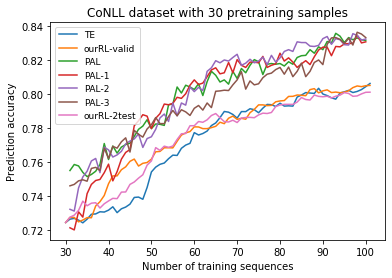

In [12]:
# sim beta
with open("./results/conll30_200_100budget_fully_none.bin", "rb") as in_file:
    (cost_1, _, _, all_acc_1, acc_valid_1) = pickle.load(in_file)
#     (cost_1, all_acc_1, acc_valid_1) = pickle.load(in_file)
       
with open("./results/conll30numembed_200_100budget_valid2VRL_all_te_acc_20step_5batch20decay_100loop-add10each10step-3_64rnn_16filter_4size_2stride.bin", "rb") as in_file:
    (cost_2, all_acc_2, acc_valid_2) = pickle.load(in_file)

with open("../PAL/results/CNNDQN-conll-20.bin", "rb") as in_file:
    (cost_3, all_acc_3, acc_valid_3) = pickle.load(in_file)

with open("../PAL/results/CNNDQN_1-conll-20.bin", "rb") as in_file:
    (cost_4, all_acc_4, acc_valid_4) = pickle.load(in_file)
    
with open("../PAL/results/CNNDQN_2-conll-20.bin", "rb") as in_file:
    (cost_5, all_acc_5, acc_valid_5) = pickle.load(in_file)

with open("../PAL/results/CNNDQN_3-conll-20.bin", "rb") as in_file:
    (cost_6, all_acc_6, acc_valid_6) = pickle.load(in_file)

with open("./results/conll30numembed_200_100budget_valid3TRL_all_te_acc_20step_5batch20decay_100loop-add10each10step-3_64rnn_16filter_4size_2stride.bin", "rb") as in_file:
    (cost_7, all_acc_7, acc_valid_7) = pickle.load(in_file)

plt.plot(cost_1, all_acc_1,
         cost_2, all_acc_2,
         cost_3[30:], all_acc_3[30:],
         cost_4[30:], all_acc_4[30:],
         cost_5[30:], all_acc_5[30:],
         cost_6[30:], all_acc_6[30:],
         cost_7, all_acc_7)
plt.legend(['TE', 'ourRL-valid', 'PAL', 'PAL-1', 'PAL-2' ,'PAL-3', 'ourRL-2test'], loc='upper left', fancybox=True, fontsize = 9)
# plt.xlim(200, 600)

plt.title('CoNLL dataset with 30 pretraining samples')
plt.xlabel('Number of training sequences')
plt.ylabel('Prediction accuracy')
plt.savefig('./results/sod.png', bbox_inches='tight')


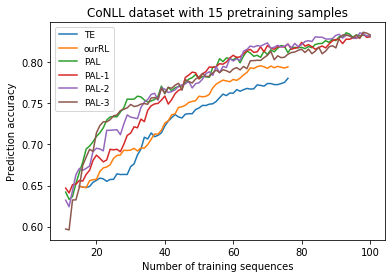

In [20]:
# sim beta
with open("./results/conll15_200_75budget_fully_none.bin", "rb") as in_file:
    (cost_1, _, _, all_acc_1, acc_valid_1) = pickle.load(in_file)
#     (cost_1, all_acc_1, acc_valid_1) = pickle.load(in_file)
       
with open("./results/conll15num_200_75budget_valid2VRL_all_te_acc_20step_5batch20decay_90loop-add10each10step-3_64rnn_16filter_4size_2stride.bin", "rb") as in_file:
    (cost_2, all_acc_2, acc_valid_2) = pickle.load(in_file)

with open("../PAL/results/CNNDQN-conll-20.bin", "rb") as in_file:
    (cost_3, all_acc_3, acc_valid_3) = pickle.load(in_file)

with open("../PAL/results/CNNDQN_1-conll-20.bin", "rb") as in_file:
    (cost_4, all_acc_4, acc_valid_4) = pickle.load(in_file)
    
with open("../PAL/results/CNNDQN_2-conll-20.bin", "rb") as in_file:
    (cost_5, all_acc_5, acc_valid_5) = pickle.load(in_file)

with open("../PAL/results/CNNDQN_3-conll-20.bin", "rb") as in_file:
    (cost_6, all_acc_6, acc_valid_6) = pickle.load(in_file)

# with open("./results/sod15num_200_testVRL_acc2_all_te_20step_5batch20decay_90loopdecay_64rnn_16filter_4size_2stride.bin", "rb") as in_file:
#     (cost_7, in_acc_7, out_acc_7, all_acc_7, acc_valid_7) = pickle.load(in_file)

plt.plot(cost_1, all_acc_1,
         cost_2, all_acc_2,
         cost_3[10:], all_acc_3[10:],
         cost_4[10:], all_acc_4[10:],
         cost_5[10:], all_acc_5[10:],
         cost_6[10:], all_acc_6[10:],)
#          cost_7, acc_valid_7)
plt.legend(['TE', 'ourRL', 'PAL', 'PAL-1', 'PAL-2' ,'PAL-3', 'RL-valid'], loc='upper left', fancybox=True, fontsize = 9)
# plt.xlim(200, 600)

plt.title('CoNLL dataset with 15 pretraining samples')
plt.xlabel('Number of training sequences')
plt.ylabel('Prediction accuracy')
plt.savefig('./results/sod.png', bbox_inches='tight')



# Uncertainty Sampling

In [ ]:
M = 20
SUBSEQ_FLAG = False
SUBSEQ_SIZE = 8
STRATEGY = 'fully'
BETA = 3.0
METHOD = 'random' #selfSim, testSim

pretrain_crf_list = data.sequence[:CRF_PRETRAIN_SIZE]
pretrain_agt_list = data.sequence[:AGENT_PRETRAIN_SIZE]
test_list = data.sequence[-TEST_SIZE:]
validation_list = data.sequence[-TEST_SIZE - VALIDATE_SIZE : -TEST_SIZE]
candidate_list  = data.sequence[AGENT_PRETRAIN_SIZE : AGENT_PRETRAIN_SIZE + CANDIDATE_SIZE]

crf = CrfModel(data, FEAT)
crf.add_instances(pretrain_agt_list)
crf.train()

# count = sum([len(seq[1]) for seq in pretrain_agt_list]) 
count = len(pretrain_agt_list)
cost_list = [count]

(in_acc, out_acc, all_acc, acc) = crf.evaluate_acc(test_list)

in_acc_list = [in_acc]
out_acc_list = [out_acc]
all_acc_list = [acc]

(in_acc, out_acc, all_acc, acc_valid) = crf.evaluate_acc(validation_list)
acc_valid_list = [acc_valid]

In [ ]:
# Vectorized and clustered test set.
Xs = [seq[0] for seq in test_list]
Xs.extend([seq[0] for seq in candidate_list])
vec, _ = string_vectorize(Xs)
validation_vec = vec[:len(test_list)].tolist()
candidate_vec = vec[len(test_list):].tolist()

print (len(validation_vec))
print (len(candidate_vec))
# Pre-calculate similarity: both between validation-test and validation-validate
sim_matrix_test = np.zeros((len(candidate_vec), len(validation_vec)))
sim_matrix_self = np.zeros((len(candidate_vec), len(candidate_vec)))
if METHOD != 'none' and METHOD != 'random':
    iterator = tqdm(range(len(candidate_vec)))
    for i in iterator:
        for j in range(len(validation_vec)):
            sim_matrix_test[i, j] = 1 - scipy.spatial.distance.cosine(candidate_vec[i], validation_vec[j])
        for j in range(len(candidate_vec)):
            sim_matrix_self[i, j] = 1 - scipy.spatial.distance.cosine(candidate_vec[i], candidate_vec[j])
    iterator.close()
print ('Similarity done!')

In [ ]:
visited_candidate_idx = []
seqs_list = []
iterator = tqdm(range(CANDIDATE_SIZE))
for seqs_size in iterator:
    if cost_list[-1] > BUDGET:
        break
    
    # Sort the test set based on confidence.
    prob_test_list = []
    for i in range(len(test_list)):
        (prob_per_token, _, prob_sum) = crf.compute_confidence(test_list[i])
        prob_test_list.append(prob_sum)
    rank_idx_test = np.argsort(np.array(prob_test_list), kind='mergesort').tolist()[::-1]

    # Calculate the average similarity between the unlabeled samples and the selected test samples.
    distance = []
    if METHOD == 'testSim':
        distance = np.sum(sim_matrix_test[:, rank_idx_test[:M]], axis=1) / M
    elif METHOD == 'selfSim':
        distance = np.sum(sim_matrix_self, axis=1) / (len(candidate_vec)-1)
        

    ####
    # Compute the top-K tokens and its seq_idx: subsequence with or without SEBSEQ_FLAG
    prob_list = []
    subseq_idx_list = []
    for i in range(len(candidate_list)):
        (prob_per_token, prob_sum) = crf.compute_entropy(candidate_list[i])
        prob_sum /= len(candidate_list[i][1])
        if STRATEGY == 'partial':
            subseq_idxs = []
            subseq_prob_sum = -sys.maxsize
            if SUBSEQ_FLAG:
                end_p = len(prob_per_token) - SUBSEQ_SIZE + 1
                for k in range(0, end_p): # the largest subsequence
                    prob_tmp = sum([prob_per_token[k+j] for j in range(SUBSEQ_SIZE)]) / SUBSEQ_SIZE
                    if prob_tmp > subseq_prob_sum:
                        subseq_prob_sum = prob_tmp
                        subseq_idxs = [k+j for j in range(SUBSEQ_SIZE)]
                if end_p < 1: # if length is not longer than subseq_size
                    subseq_prob_sum = prob_sum / len(prob_per_token)
                    subseq_idxs = range(0, len(prob_per_token))
            else:
                token_sorted = np.argsort(np.array(prob_per_token), kind='mergesort').tolist()[::-1]
                subseq_idxs = [token_sorted[k] for k in range(min(SUBSEQ_SIZE, len(prob_per_token)))]
                subseq_prob_sum = sum([prob_per_token[k] for k in subseq_idxs]) / len(subseq_idxs)
            prob_sum = subseq_prob_sum
            subseq_idx_list.append(subseq_idxs)

        prob_list.append(prob_sum)
    
    # Entropy weighted with or without similarity
    mean_prob = np.mean(prob_list)
    std_prob = np.std(prob_list)
    prob_list = [(prob_list[i] - mean_prob) / std_prob for i in range(len(candidate_list))]

    # norm_dist = [1/(1+math.exp(x)) for x in norm_dist]
    score_list = []
    for i in range(len(candidate_list)):
        if METHOD == 'none':
            score_list.append(prob_list[i])
        elif METHOD != 'random':
            score_list.append(prob_list[i] * math.pow(distance[i], BETA))
    
    # Locate the subseq_idx with largest score
    rank_idx = np.argsort(np.array(score_list), kind='mergesort').tolist()[::-1]
    if METHOD == 'random':
        rand_idx = random.shuffle(list(range(len(score_list))))
        
    for i in rank_idx:
        if i not in visited_candidate_idx:
            seq_idx = i
            visited_candidate_idx.append(seq_idx)
            break
    query_seq = candidate_list[seq_idx]
    
    if STRATEGY == 'partial':
        subseq_idxs = subseq_idx_list[seq_idx]
        predict_y = crf.predict(query_seq)
        for i in range(len(query_seq[1])):
            if i not in subseq_idxs:
                query_seq[1][i] = predict_y[i]
        count += len(subseq_idxs)
    else:
#         count += len(query_seq[1])
        count += 1
    cost_list.append(count)
    
    crf.add_instances([query_seq])
    seqs_list.append(query_seq)
    crf.train()
    (in_acc, out_acc, all_acc, acc) = crf.evaluate_acc(test_list)
    in_acc_list.append(in_acc)
    out_acc_list.append(out_acc)
    all_acc_list.append(acc)
    
    (in_acc, out_acc, all_acc, acc_valid) = crf.evaluate_acc(validation_list)
    acc_valid_list.append(acc_valid)
iterator.close()
print ('Done!') 

In [ ]:
filename = "./results/" + SOURCE + str(AGENT_PRETRAIN_SIZE) + "_" + str(VALIDATE_SIZE) + "_" + str(BUDGET) + "budget_" + STRATEGY + "_" + METHOD 
if STRATEGY == 'partial':
    filename += "_sub" + str(SUBSEQ_SIZE) + str(SUBSEQ_FLAG)
if METHOD != 'none' and METHOD != 'random':
    filename += "_beta" + str(BETA)
    if METHOD == 'testSim':
        filename += "_M" + str(M)
filename += ".bin"

with open(filename, "wb") as result:
    pickle.dump((cost_list, in_acc_list, out_acc_list, all_acc_list, acc_valid_list), result)

### sanity check

In [ ]:
select_q = gen_dataDistr(seqsq_list + pretrain_agt_list)
rand_q = gen_dataDistr(seqsr_list + pretrain_agt_list)
print ("selected set has {} formats".format(len(select_q)))
print ("rand set has {} formats".format(len(rand_q)))

# for rank, key in enumerate(sorted(uniques, key=uniques.get, reverse=True), 1):
#     print (rank, key)

data_dict = add_dataformat({}, test_list)
data_dict = add_dataformat(data_dict, validation_list)
data_dict = add_dataformat(data_dict, seqsq_list + seqsr_list + pretrain_agt_list)
data_dict = add_dataformat(data_dict, candidate_list)
print ("{} formats overall".format(len(data_dict)))

for key, value in data_dict.items():
    print ("{}: {}".format(key, str(value)))


In [ ]:
select_test_ratio = len(set.intersection(set(test_q.keys()),set(select_q.keys()))) / len(test_q)
print ("select & test / test: {}".format(select_test_ratio))

select_valid_ratio = len(set.intersection(set(valid_q.keys()),set(select_q.keys()))) / len(valid_q)
print ("select & valid / valid: {}".format(select_valid_ratio))

In [ ]:
x1 = []
y1 = []
for key, value in test_q.items():
    x1.append(data_dict[key])
    y1.append(value)
l1 = plt.bar(x1, y1)

x2 = []
y2 = []
for key, value in valid_q.items():
    x2.append(data_dict[key])
    y2.append(value)
l2 = plt.bar(x2, y2)

x3 = []
y3 = []
for key, value in select_q.items():
    x3.append(data_dict[key])
    y3.append(value)
l3 = plt.bar(x3, y3)

x4 = []
y4 = []
for key, value in rand_q.items():
    x4.append(data_dict[key])
    y4.append(value)
l4 = plt.bar(x4, y4)

plt.title('data distribution')
# plt.xlim(-5, 155)
plt.legend((l1, l2, l3, l4), ('test', 'validation', 'select', 'rand'))
# plt.show()

# x4 = []
# y4 = []
# for key, value in candidate_q.items():
#     x4.append(data_dict[key])
#     y4.append(value)
# plt.bar(x4, y4)
# plt.title('candidate distribution')
# plt.xlim(-5, 155)
plt.savefig(filename + '_distr.png')

In [ ]:
# partial window size w
# sod: w=9
# sdh: w=8
# ibm: w=17

# SOD
with open("./results1/sod_fully_none_Truenorm.bin", "rb") as in_file:
    (cost_f, in_acc_f, out_acc_f, all_acc_f) = pickle.load(in_file)
       
with open("./results1/sod1000_fully_selfSim_beta3.0_Truenorm.bin", "rb") as in_file:
    (cost_8, in_acc_8, out_acc_8, all_acc_8) = pickle.load(in_file)
    
with open("./results1/sod_partial_none_sub9False_Falsenorm.bin", "rb") as in_file:
    (cost_9, in_acc_9, out_acc_9, all_acc_9) = pickle.load(in_file)

with open("./results1/sod_partial_selfSim_sub8False_beta1.0_Falsenorm.bin", "rb") as in_file:
    (cost_11, in_acc_11, out_acc_11, all_acc_11) = pickle.load(in_file)

with open("./results1/sod1000_partial_selfSim_sub8False_beta3.0_Truenorm.bin", "rb") as in_file:
    (cost_self_part, in_acc_self_part, out_acc_self_part, all_acc_self_part) = pickle.load(in_file)

with open("./results1/sod_fully_testSim_beta1.0_M100_Falsenorm.bin", "rb") as in_file:
    (cost_test_part, in_acc_test_part, out_acc_test_part, all_acc_test_part) = pickle.load(in_file)

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
fig, axes = plt.subplots(ncols=3, nrows=1)
ax = axes.flatten()

ax[0].set_xlabel("Number of training labels", fontsize=21)
ax[0].set_ylabel("Predictive accuracy", fontsize=21)
ax[0].tick_params(axis = 'both', which = 'major', labelsize = 17)
ax[1].tick_params(axis = 'both', which = 'major', labelsize = 17)
ax[2].tick_params(axis = 'both', which = 'major', labelsize = 17)
ax[0].grid()
ax[0].plot(cost_f, all_acc_f, linestyle=':')
ax[0].plot(cost_8, all_acc_8, linestyle='--')
ax[0].plot(cost_9, all_acc_9)
ax[0].plot(cost_11, all_acc_11)
ax[0].plot(cost_self_part, all_acc_self_part)
ax[0].plot(cost_test_part, all_acc_test_part, c='black')
ax[0].set_xlim([200,600])
ax[0].set_title('Building A', fontsize=22)
leg = ax[0].legend(['TE', 'denTE', 'TE-part', 'transTE', 'denTE-part', 'transTE-part'], 
                   loc='lower right', fancybox=True, fontsize = 16)
leg.get_frame().set_alpha(0.7)
# plt.subplots_adjust(hspace=0.5)


# SDH
with open("./results1/sdh_fully_none_Falsenorm.bin", "rb") as in_file:
    (cost2_f, in2_acc_f, out_acc_f, all2_acc_f) = pickle.load(in_file)
       
with open("./results1/sdh_fully_selfSim_beta1.0_Truenorm.bin", "rb") as in_file:
    (cost2_8, in2_acc_8, out_acc_8, all2_acc_8) = pickle.load(in_file)
    
with open("./results1/sdh_partial_none_sub8False_Falsenorm.bin", "rb") as in_file:
    (cost2_9, in2_acc_9, out_acc_9, all2_acc_9) = pickle.load(in_file)

with open("./results1/sdh_fully_testSim_beta1.0_M100_Falsenorm.bin", "rb") as in_file:
    (cost2_11, in2_acc_11, out_acc_11, all2_acc_11) = pickle.load(in_file)

with open("./results1/sdh_partial_selfSim_sub8False_beta0.5_Truenorm.bin", "rb") as in_file:
    (cost2_self_part, in2_acc_self_part, out_acc_self_part, all2_acc_self_part) = pickle.load(in_file)

with open("./results1/sdh1000_partial_testSim_sub8False_beta1.0_M100_Falsenorm.bin", "rb") as in_file:
    (cost2_test_part, in2_acc_test_part, out_acc_test_part, all2_acc_test_part) = pickle.load(in_file)


ax[1].set_xlabel("Number of training labels", fontsize=21)
ax[1].set_ylabel("Predictive accuracy", fontsize=21)
ax[1].tick_params(axis = 'both', which = 'major', labelsize = 17)
ax[1].grid()
ax[1].plot(cost2_f, all2_acc_f, linestyle=":")
ax[1].plot(cost2_8, all2_acc_8, linestyle='--')
ax[1].plot(cost2_9, all2_acc_9)
ax[1].plot(cost2_11, all2_acc_11)
ax[1].plot(cost2_self_part, all2_acc_self_part)
ax[1].plot(cost2_test_part, all2_acc_test_part, c='black')
ax[1].set_ylim([0.85, 0.978])
ax[1].set_xlim([300,1000])
ax[1].set_title('Building B', fontsize=22)
leg = ax[1].legend(['TE', 'denTE', 'TE-part', 'transTE', 'denTE-part', 'transTE-part'], 
                   loc='lower right', fancybox=True, fontsize = 16)
leg.get_frame().set_alpha(0.7)

# IBM
with open("./results1/ibm_partial_none_sub15False_Falsenorm.bin", "rb") as in_file:
    (cost3_f, in3_acc_f, out_acc_f, all3_acc_f) = pickle.load(in_file)
       
with open("./results1/ibm1000_partial_testSim_sub13False_beta1.0_M10_Falsenorm.bin", "rb") as in_file:
    (cost3_8, in3_acc_8, out_acc_8, all3_acc_8) = pickle.load(in_file)
    
with open("./results1/ibm_partial_none_sub19False_Falsenorm.bin", "rb") as in_file:
    (cost3_9, in3_acc_9, out_acc_9, all3_acc_9) = pickle.load(in_file)

with open("./results1/ibm_fully_testSim_beta1.0_M100_Falsenorm.bin", "rb") as in_file:
    (cost3_11, in3_acc_11, out_acc_11, all3_acc_11) = pickle.load(in_file)

with open("./results1/ibm_partial_selfSim_sub17False_beta1.0_Falsenorm.bin", "rb") as in_file:
    (cost3_self_part, in3_acc_self_part, out_acc_self_part, all3_acc_self_part) = pickle.load(in_file)

with open("./results1/ibm_fully_none_Falsenorm.bin", "rb") as in_file:
    (cost3_test_part, in3_acc_test_part, out_acc_test_part, all3_acc_test_part) = pickle.load(in_file)


ax[2].set_xlabel("Number of training labels", fontsize=21)
ax[2].set_ylabel("Predictive accuracy", fontsize=21)
ax[2].tick_params(axis = 'both', which = 'major', labelsize = 17)
ax[2].grid()
ax[2].plot(cost3_f, all3_acc_f, linestyle=":")
ax[2].plot(cost3_8, all3_acc_8, linestyle='--')
ax[2].plot(cost3_9, all3_acc_9)
ax[2].plot(cost3_11, all3_acc_11)
ax[2].plot(cost3_self_part, all3_acc_self_part)
ax[2].plot(cost3_test_part, all3_acc_test_part, c='black')
ax[2].set_ylim([0.745, 0.924])
ax[2].set_xlim([200,1000])
ax[2].set_title('Building C', fontsize=22)
leg = ax[2].legend(['TE', 'denTE', 'TE-part', 'transTE', 'denTE-part', 'transTE-part'], 
                   loc='lower right', fancybox=True, fontsize = 16)
leg.get_frame().set_alpha(0.7)

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(28,4)
plt.show()

In [ ]:
# partial window size w
# sod: w=9
# sdh: w=8
# ibm: w=17

# SOD
with open("./results/sod_fully_none_Truenorm.bin", "rb") as in_file:
    (cost_f, in_acc_f, out_acc_f, all_acc_f) = pickle.load(in_file)
       
with open("./results/sod1000_partial_none_sub5False_Falsenorm.bin", "rb") as in_file:
    (cost_8, in_acc_8, out_acc_8, all_acc_8) = pickle.load(in_file)
    
with open("./results/sod_partial_none_sub9False_Falsenorm.bin", "rb") as in_file:
    (cost_9, in_acc_9, out_acc_9, all_acc_9) = pickle.load(in_file)

with open("./results/sod_partial_none_sub12False_Falsenorm.bin", "rb") as in_file:
    (cost_11, in_acc_11, out_acc_11, all_acc_11) = pickle.load(in_file)

# plt.rc('text', usetex=True)
# plt.rc('font', family='arial')
fig, axes = plt.subplots(ncols=3, nrows=1)
ax = axes.flatten()

ax[0].set_xlabel("Number of training labels", fontsize=21)
ax[0].set_ylabel("Predictive accuracy", fontsize=21)
ax[0].tick_params(axis = 'both', which = 'major', labelsize = 17)
ax[1].tick_params(axis = 'both', which = 'major', labelsize = 17)
ax[2].tick_params(axis = 'both', which = 'major', labelsize = 17)
ax[0].grid()
ax[0].plot(cost_f, all_acc_f, linestyle=':')
ax[0].plot(cost_8, all_acc_8, c='orange')
ax[0].plot(cost_9, all_acc_9, c='green')
ax[0].plot(cost_11, all_acc_11, c='red')
ax[0].set_xlim([200,600])
ax[0].set_title('Building A', fontsize=22)
leg = ax[0].legend(['Full', r'w=5', r'w=9', r'w=12'], loc='lower right', fancybox=True, fontsize = 16)
leg.get_frame().set_alpha(0.7)
# plt.subplots_adjust(hspace=0.5)


# SDH
with open("./results/sdh_fully_none_Falsenorm.bin", "rb") as in_file:
    (cost2_f, in2_acc_f, out_acc_f, all2_acc_f) = pickle.load(in_file)
       
with open("./results/sdh_partial_none_sub5False_Falsenorm.bin", "rb") as in_file:
    (cost2_8, in2_acc_8, out_acc_8, all2_acc_8) = pickle.load(in_file)
    
with open("./results/sdh_partial_none_sub8False_Falsenorm.bin", "rb") as in_file:
    (cost2_9, in2_acc_9, out_acc_9, all2_acc_9) = pickle.load(in_file)

with open("./results/sdh_partial_none_sub14False_Falsenorm.bin", "rb") as in_file:
    (cost2_11, in2_acc_11, out_acc_11, all2_acc_11) = pickle.load(in_file)

ax[1].set_xlabel("Number of training labels", fontsize=21)
ax[1].set_ylabel("Predictive accuracy", fontsize=21)
ax[1].tick_params(axis = 'both', which = 'major', labelsize = 17)
ax[1].grid()
ax[1].plot(cost2_f, all2_acc_f, linestyle=":")
ax[1].plot(cost2_8, all2_acc_8, c='orange')
ax[1].plot(cost2_9, all2_acc_9, c='green')
ax[1].plot(cost2_11, all2_acc_11, c='red')
ax[1].set_ylim([0.83, 0.978])
ax[1].set_xlim([300,1000])
ax[1].set_title('Building B', fontsize=22)
leg = ax[1].legend(['Full', 'w=5', 'w=8', 'w=14'],
                   loc='lower right', fancybox=True, fontsize = 16)
leg.get_frame().set_alpha(0.7)

# IBM
with open("./results/ibm_partial_none_sub15False_Falsenorm.bin", "rb") as in_file:
    (cost3_f, in3_acc_f, out_acc_f, all3_acc_f) = pickle.load(in_file)
       
with open("./results/ibm_partial_none_sub11False_Falsenorm.bin", "rb") as in_file:
    (cost3_8, in3_acc_8, out_acc_8, all3_acc_8) = pickle.load(in_file)
    
with open("./results/ibm_partial_none_sub19False_Falsenorm.bin", "rb") as in_file:
    (cost3_9, in3_acc_9, out_acc_9, all3_acc_9) = pickle.load(in_file)

with open("./results/ibm_partial_none_sub7False_Falsenorm.bin", "rb") as in_file:
    (cost3_11, in3_acc_11, out_acc_11, all3_acc_11) = pickle.load(in_file)

ax[2].set_xlabel("Number of training labels", fontsize=21)
ax[2].set_ylabel("Predictive accuracy", fontsize=21)
ax[2].tick_params(axis = 'both', which = 'major', labelsize = 17)
ax[2].grid()
ax[2].plot(cost3_f, all3_acc_f, linestyle=':')
ax[2].plot(cost3_8, all3_acc_8, c='orange')
ax[2].plot(cost3_9, all3_acc_9, c='green')
ax[2].plot(cost3_11, all3_acc_11, c='red')
ax[2].set_xlim([200,1000])
# ax[2].set_ylim([0.83, 0.978])
ax[2].set_title('Building C', fontsize=22)
leg = ax[2].legend(['Full', 'w=15', 'w=19', 'w=23'], 
                   loc='lower right', fancybox=True, fontsize = 16)
leg.get_frame().set_alpha(0.7)

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(28,4)
plt.show()
# plt.tick_params(labelsize=20)
# plt.savefig('perp1.png', bbox_inches='tight')
    
# plt.plot(cost_f, all_acc_f,
#          cost_8, all_acc_8,
#          cost_9, all_acc_9,
#          cost_11, all_acc_11,
#          cost_self_part, all_acc_self_part,
#          cost_test_part, all_acc_test_part)
# plt.legend(['TE', 'denTE', 'TE-part', 'transTE', 'denTE-part', 'transTE-part'], loc='lower right', fancybox=True, fontsize = 12)
# # plt.ylim(0.86, 0.97)

# plt.title('SOD dataset with 5 pretraining samples')
# plt.xlabel('Number of training labels')
# plt.ylabel('Prediction accuracy')
# plt.savefig('./results/sod.png', bbox_inches='tight')
# plt.show()